In [10]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torchvision.transforms as transforms
from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
# Load images from KITTI directory
test_dir = "/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2"
train_dir = "/kaggle/input/kitti-dataset/data_object_image_2/training/image_2"

In [20]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import numpy as np

class KITTIDataset(Dataset):
    def __init__(self, image_dir, condition_type="edge", image_size=(256, 256), transform=None):
        """
        Args:
            image_dir (str): Path to the directory with images.
            condition_type (str): Type of condition to generate ("edge" or "segmentation").
            image_size (tuple): Size to resize the images.
            transform (callable, optional): Optional transform to apply to the images.
        """
        self.image_dir = image_dir
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
        self.condition_type = condition_type
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load RGB image using PIL (for compatibility with torchvision.transforms)
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')  # Ensure RGB format

        # Apply transforms
        if self.transform:
            img = self.transform(img)  # Apply transformation pipeline here

        # Generate condition input (e.g., edge map)
        condition = self._generate_condition(img)

        return condition, img

    def _generate_condition(self, img):
        """
        Generates the condition input based on the selected condition type.
        Args:
            img (torch.Tensor): The transformed image.

        Returns:
            torch.Tensor: The condition input.
        """
        # Convert transformed tensor back to NumPy array for edge detection
        img_np = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)  # Convert tensor to [0, 255] range

        # Generate edge map
        if self.condition_type == "edge":
            gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
            edges = cv2.Canny(gray, threshold1=100, threshold2=200)  # Apply Canny edge detection
            edges = cv2.resize(edges, self.image_size)  # Resize to match image size
            condition = torch.tensor(edges[np.newaxis, :, :], dtype=torch.float32) / 255.0  # Normalize to [0, 1]
        else:
            raise NotImplementedError("Only 'edge' condition is implemented")

        return condition

In [21]:
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

def get_kitti_transforms(image_size=(256, 256)):
    """
    Returns a set of transformations for preprocessing the KITTI dataset.
    
    Args:
        image_size (tuple): The desired size to resize the images (H, W).

    Returns:
        transform (torchvision.transforms.Compose): A composed set of transformations.
    """
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.Resize(image_size, interpolation=InterpolationMode.BILINEAR),
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
    ])

In [36]:
import matplotlib.pyplot as plt

def visualize_kitti_data(dataset, num_samples=5):
    """
    Visualize a few samples from the KITTI dataset along with their conditions.
    
    Args:
        dataset (KITTIDataset): The dataset object.
        num_samples (int): Number of samples to visualize.
    """
    # Set up a figure for visualization
    plt.figure(figsize=(10, num_samples * 3))
    
    for i in range(num_samples):
        # Get a sample from the dataset
        condition, img = dataset[i]
        
        # Denormalize the image for visualization (from [-1, 1] to [0, 1])
        img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Convert to HWC and scale to [0, 1]
        img = img.clip(0, 1)  # Ensure no values are outside [0, 1]
        
        # Get the condition map (e.g., edge map)
        condition_map = condition[0].numpy()  # Convert condition tensor to numpy array
        
        # Plot the transformed image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(img)
        plt.title(f"Image {i + 1}")
        plt.axis("off")
        
        # Plot the condition map
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(condition_map, cmap="gray")
        plt.title(f"Condition {i + 1}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

Batch 0:
  Conditions shape: torch.Size([32, 1, 256, 256])
  Images shape: torch.Size([32, 3, 256, 256])


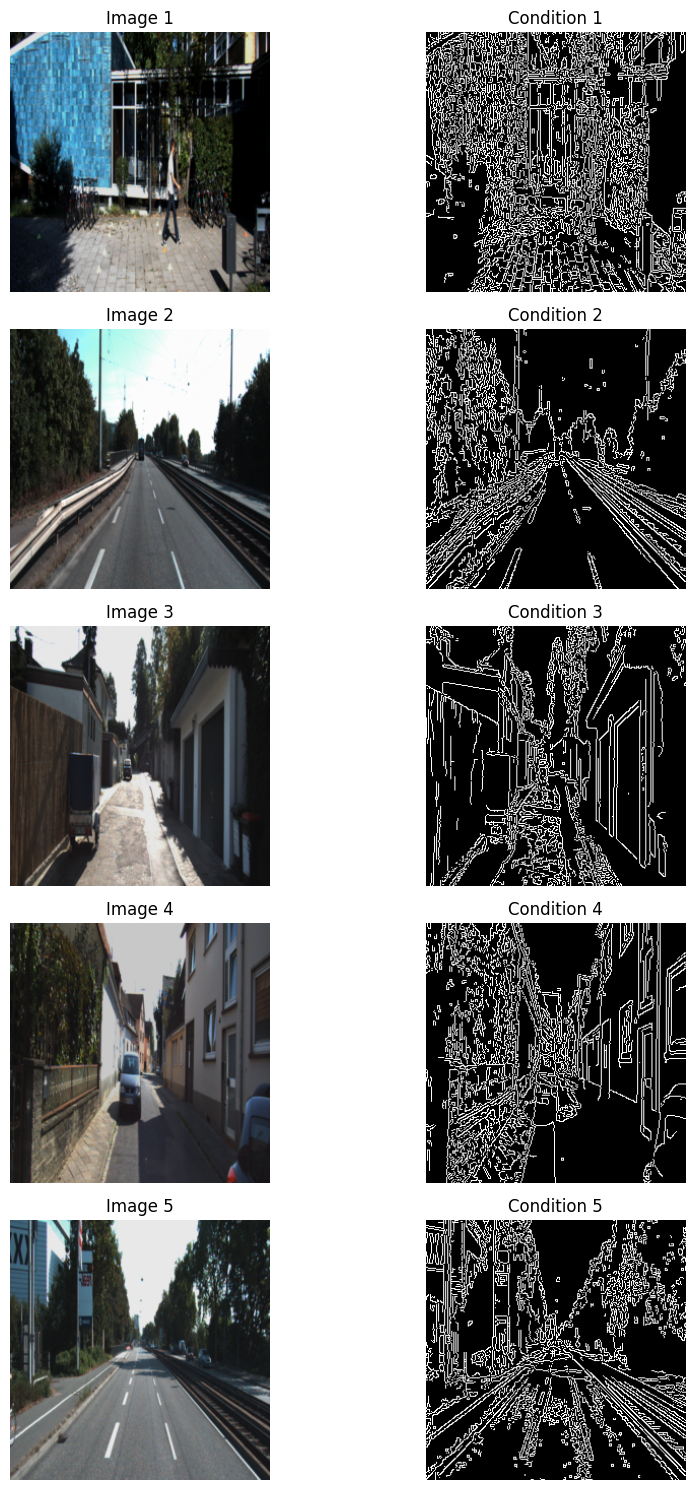

In [37]:
from torch.utils.data import DataLoader, random_split

kitti_transform = get_kitti_transforms(image_size=(256, 256))

# Initialize dataset
dataset = KITTIDataset(image_dir=train_dir, condition_type="edge", image_size=(256, 256), transform=kitti_transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Test DataLoader
for batch_idx, (conditions, images) in enumerate(train_loader):
    print(f"Batch {batch_idx}:")
    print(f"  Conditions shape: {conditions.shape}")  # Shape: (B, 1, H, W)
    print(f"  Images shape: {images.shape}")  # Shape: (B, 3, H, W)
    break

# Visualize 5 samples
visualize_kitti_data(dataset, num_samples=5)

# Implementing Conditional GAN below

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


In [ ]:
class Generator2(nn.Module):
    def __init__(self, noise_dim, condition_channels, image_channels, pretrained=True):
        super(Generator, self).__init__()
        
        # Load pretrained ResNet-18 model
        resnet = resnet18(pretrained=pretrained)
        self.condition_encoder = nn.Sequential(*list(resnet.children())[:-2])  # Use until feature map layer

        # Freeze ResNet layers
        for param in self.condition_encoder.parameters():
            param.requires_grad = True
        
        self.condition_projector = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=4, stride=4)
        
        self.fc = nn.Sequential(
            nn.Linear(noise_dim + 64 * 64, 256),
            nn.BatchNorm1d(256),  # Apply BatchNorm1d
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),  # Apply BatchNorm1d
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),  # Apply BatchNorm1d
            nn.ReLU(),
            nn.Linear(1024, image_channels * 256 * 256),
            nn.Tanh()
        )
        self.image_channels = image_channels

    def forward(self, noise, condition):
        # Project condition to latent space
        condition_projected = self.condition_projector(condition)  # Shape: (B, 1, H', W')
        condition_flat = condition_projected.view(condition_projected.size(0), -1)  # Flatten
        # Concatenate noise and condition
        x = torch.cat([noise, condition_flat], dim=1)
        # Pass through the generator
        x = self.fc(x)
        return x.view(x.size(0), self.image_channels, 256, 256)  # Reshape to image


In [54]:
class Generator(nn.Module):
    def __init__(self, noise_dim, condition_channels, image_channels, pretrained=True):
        super(Generator, self).__init__()
        
        # Load pretrained ResNet-18 model
        resnet = resnet18(pretrained=pretrained)
        self.condition_encoder = nn.Sequential(*list(resnet.children())[:-2])  # Use until feature map layer

        # Freeze ResNet layers
        for param in self.condition_encoder.parameters():
            param.requires_grad = True
        
        self.condition_projector = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=4, stride=4)
        self.fc = nn.Sequential(
            nn.Linear(noise_dim + 64 * 64, 256),  # Adjust based on projection
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, image_channels * 256 * 256),
            nn.Tanh()
        )
        self.image_channels = image_channels

    def forward(self, noise, condition):
        # Project condition to latent space
        condition_projected = self.condition_projector(condition)  # Shape: (B, 1, H', W')
        condition_flat = condition_projected.view(condition_projected.size(0), -1)  # Flatten
        # Concatenate noise and condition
        x = torch.cat([noise, condition_flat], dim=1)
        # Pass through the generator
        x = self.fc(x)
        return x.view(x.size(0), self.image_channels, 256, 256)  # Reshape to image

In [55]:
import torch.nn as nn

class Discriminator2(nn.Module):
    def __init__(self, image_channels, condition_dim, pretrained=True):
        super(Discriminator, self).__init__()

        # Load pretrained ResNet-18 model
        resnet = resnet18(pretrained=pretrained)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove the classification head

        # Freeze ResNet layers
        for param in self.feature_extractor.parameters():
            param.requires_grad = True
        
        # Condition projector to match the Generator's projection
        self.condition_projector = nn.Conv2d(
            in_channels=1, 
            out_channels=1, 
            kernel_size=4, 
            stride=4
        )  # Projects (1, 256, 256) -> (1, 64, 64)
        
        self.model = nn.Sequential(
            nn.Linear(image_channels * 256 * 256 + condition_dim, 1024),
            nn.BatchNorm1d(1024),  # Apply BatchNorm1d
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),  # Apply BatchNorm1d
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),  # Apply BatchNorm1d
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, image, condition):
        # Flatten the image
        image_flat = image.view(image.size(0), -1)  # Shape: (B, 3*256*256)
        
        # Project and flatten the condition
        condition_projected = self.condition_projector(condition)  # Shape: (B, 1, 64, 64)
        condition_flat = condition_projected.view(condition_projected.size(0), -1)  # Shape: (B, 4096)
        
        # Concatenate image and condition
        x = torch.cat([image_flat, condition_flat], dim=1)  # Shape: (B, 3*256*256 + 4096)
        output = self.model(x)
        
        return output


In [56]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, image_channels, condition_dim, pretrained=True):
        super(Discriminator, self).__init__()

        # Load pretrained ResNet-18 model
        resnet = resnet18(pretrained=pretrained)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove the classification head

        # Freeze ResNet layers
        for param in self.feature_extractor.parameters():
            param.requires_grad = True
        
        # Condition projector to match the Generator's projection
        self.condition_projector = nn.Conv2d(
            in_channels=1, 
            out_channels=1, 
            kernel_size=4, 
            stride=4
        )  # Projects (1, 256, 256) -> (1, 64, 64)
        
        self.model = nn.Sequential(
            nn.Linear(image_channels * 256 * 256 + condition_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, image, condition):
        # Flatten the image
        image_flat = image.view(image.size(0), -1)  # Shape: (B, 3*256*256)
        
        # Project and flatten the condition
        condition_projected = self.condition_projector(condition)  # Shape: (B, 1, 64, 64)
        condition_flat = condition_projected.view(condition_projected.size(0), -1)  # Shape: (B, 4096)
        
        # Concatenate image and condition
        x = torch.cat([image_flat, condition_flat], dim=1)  # Shape: (B, 3*256*256 + 4096)
        output = self.model(x)
        
        return output


In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [58]:
from torch.optim.lr_scheduler import StepLR
from torchvision.models import resnet18

# Dimensions
noise_dim = 100
condition_dim = 64 * 64  # Size of flattened condition (1 channel, 256x256)
image_channels = 3

# Models
generator = Generator(noise_dim, condition_dim, image_channels).to(device)
discriminator = Discriminator(image_channels, condition_dim).to(device)
#generator = Generator(noise_dim, image_channels).to(device)
#discriminator = Discriminator(image_channels).to(device)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

g_optimizer = optim.Adam([
    {'params': generator.condition_encoder.parameters(), 'lr': 1e-5},  # Lower learning rate for ResNet
    {'params': generator.fc.parameters(), 'lr': 1e-4}  # Higher learning rate for custom layers
], betas=(0.5, 0.999), weight_decay=1e-4)

d_optimizer = optim.Adam([
    {'params': discriminator.feature_extractor.parameters(), 'lr': 1e-5},  # Lower learning rate for ResNet
    {'params': discriminator.model.parameters(), 'lr': 2e-4}  # Higher learning rate for custom layers
], betas=(0.5, 0.999), weight_decay=1e-4)

g_scheduler = StepLR(g_optimizer, step_size=30, gamma=0.1)
d_scheduler = StepLR(d_optimizer, step_size=30, gamma=0.1)

# Loss
criterion = nn.BCELoss()


### Utility Functions

In [59]:
import matplotlib.pyplot as plt

def generate_and_save_images(generator, fixed_noise, fixed_conditions, epoch, num_samples=8, save_dir='generated_images'):
    """
    Generates and plots/saves images using the generator based on fixed noise and conditions.

    Args:
        generator (nn.Module): The generator model.
        fixed_noise (Tensor): Fixed noise vectors.
        fixed_conditions (Tensor): Fixed condition inputs.
        epoch (int): Current epoch number.
        num_samples (int): Number of samples to generate and display.
        save_dir (str): Directory to save the generated images.
    """
    generator.eval()
    with torch.no_grad():
        fake_images = generator(fixed_noise, fixed_conditions[:num_samples])
        fake_images = (fake_images + 1.0) / 2.0
        fake_images = fake_images.cpu().numpy()
        conditions = fixed_conditions[:num_samples].cpu().numpy()

    generator.train()

    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Plotting and saving
    plt.figure(figsize=(12, num_samples * 3))
    for i in range(num_samples):
        # Condition (Edge Map)
        plt.subplot(num_samples, 2, 2*i + 1)
        condition_img = conditions[i][0]
        plt.imshow(condition_img, cmap='gray')
        plt.title(f"Condition {i+1}")
        plt.axis('off')
        
        # Generated Image
        plt.subplot(num_samples, 2, 2*i + 2)
        generated_img = fake_images[i].transpose(1, 2, 0)
        plt.imshow(generated_img)
        plt.title(f"Generated {i+1}")
        plt.axis('off')
        
        # Save individual generated images
        #img_path = os.path.join(save_dir, f"epoch_{epoch+1}_sample_{i+1}.png")
        #plt.imsave(img_path, generated_img)
    
    plt.tight_layout()
    plt.suptitle(f"Epoch {epoch+1} Generated Samples", fontsize=16, y=1.02)
    plt.show()

In [60]:
import os

# Define directories
checkpoint_dir = 'checkpoints'
generated_images_dir = 'generated_images'

# Create directories if they don't exist
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(generated_images_dir, exist_ok=True)

In [61]:
import os
import torch
import glob

def save_checkpoint(generator, discriminator, g_optimizer, d_optimizer, epoch, checkpoint_dir='checkpoints'):
    """
    Saves the generator and discriminator states along with their optimizers to separate checkpoint files.
    Maintains only the latest checkpoint by deleting the previous one.

    Args:
        generator (nn.Module): The generator model.
        discriminator (nn.Module): The discriminator model.
        g_optimizer (Optimizer): Generator optimizer.
        d_optimizer (Optimizer): Discriminator optimizer.
        epoch (int): Current epoch number.
        checkpoint_dir (str): Directory to save the checkpoints.
    """
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Define checkpoint filenames with epoch numbers
    generator_path = os.path.join(checkpoint_dir, f'generator_epoch_{epoch}.pth')
    discriminator_path = os.path.join(checkpoint_dir, f'discriminator_epoch_{epoch}.pth')
    g_optimizer_path = os.path.join(checkpoint_dir, f'g_optimizer_epoch_{epoch}.pth')
    d_optimizer_path = os.path.join(checkpoint_dir, f'd_optimizer_epoch_{epoch}.pth')
    
    # Save Generator state_dict
    torch.save(generator.state_dict(), generator_path)
    print(f"Generator checkpoint saved at '{generator_path}'.")
    
    # Save Discriminator state_dict
    torch.save(discriminator.state_dict(), discriminator_path)
    print(f"Discriminator checkpoint saved at '{discriminator_path}'.")
    
    # Save Generator Optimizer state_dict
    torch.save(g_optimizer.state_dict(), g_optimizer_path)
    print(f"Generator optimizer checkpoint saved at '{g_optimizer_path}'.")
    
    # Save Discriminator Optimizer state_dict
    torch.save(d_optimizer.state_dict(), d_optimizer_path)
    print(f"Discriminator optimizer checkpoint saved at '{d_optimizer_path}'.")
    
    # Delete previous checkpoints (keep only the latest one)
    # Find all generator and discriminator checkpoint files
    generator_checkpoints = sorted(glob.glob(os.path.join(checkpoint_dir, 'generator_epoch_*.pth')),
                                   key=lambda x: int(x.split('_')[-1].split('.pth')[0]))
    discriminator_checkpoints = sorted(glob.glob(os.path.join(checkpoint_dir, 'discriminator_epoch_*.pth')),
                                       key=lambda x: int(x.split('_')[-1].split('.pth')[0]))
    g_optimizer_checkpoints = sorted(glob.glob(os.path.join(checkpoint_dir, 'g_optimizer_epoch_*.pth')),
                                     key=lambda x: int(x.split('_')[-1].split('.pth')[0]))
    d_optimizer_checkpoints = sorted(glob.glob(os.path.join(checkpoint_dir, 'd_optimizer_epoch_*.pth')),
                                     key=lambda x: int(x.split('_')[-1].split('.pth')[0]))
    
    # Define a helper function to delete older checkpoints
    def delete_old_checkpoints(checkpoints):
        while len(checkpoints) > 1:
            oldest = checkpoints.pop(0)
            os.remove(oldest)
            print(f"Deleted old checkpoint: '{oldest}'")
    
    # Delete older checkpoints
    delete_old_checkpoints(generator_checkpoints)
    delete_old_checkpoints(discriminator_checkpoints)
    delete_old_checkpoints(g_optimizer_checkpoints)
    delete_old_checkpoints(d_optimizer_checkpoints)


In [62]:
import os
import torch
import glob

def load_checkpoint_without_optimizers(generator, discriminator, checkpoint_dir='checkpoints', device='cpu'):
    """
    Loads the latest generator and discriminator checkpoints but skips loading optimizers.
    Reinitializes the optimizers to avoid mismatches.

    Args:
        generator (nn.Module): The generator model.
        discriminator (nn.Module): The discriminator model.
        checkpoint_dir (str): Directory where checkpoints are saved.
        device (torch.device): Device to map the loaded tensors.

    Returns:
        start_epoch (int): The epoch to start/resume training from.
    """
    # Find all generator and discriminator checkpoint files
    generator_checkpoints = sorted(glob.glob(os.path.join(checkpoint_dir, 'generator_epoch_*.pth')),
                                   key=lambda x: int(x.split('_')[-1].split('.pth')[0]))
    discriminator_checkpoints = sorted(glob.glob(os.path.join(checkpoint_dir, 'discriminator_epoch_*.pth')),
                                       key=lambda x: int(x.split('_')[-1].split('.pth')[0]))

    if not generator_checkpoints or not discriminator_checkpoints:
        print("No checkpoints found. Starting training from scratch.")
        return 0

    # Load the latest checkpoint
    latest_generator_checkpoint = generator_checkpoints[-1]
    latest_discriminator_checkpoint = discriminator_checkpoints[-1]
    latest_epoch = int(latest_generator_checkpoint.split('_')[-1].split('.pth')[0])

    print(f"Loading checkpoints from epoch {latest_epoch}...")

    # Load model weights
    generator.load_state_dict(torch.load(latest_generator_checkpoint, map_location=device))
    discriminator.load_state_dict(torch.load(latest_discriminator_checkpoint, map_location=device))
    print(f"Loaded Generator and Discriminator from checkpoints.")

    print("Skipping optimizer states. Optimizers will be reinitialized.")
    return latest_epoch + 1

In [63]:
import os
import torch
import glob
from torch.optim import Adam

def load_checkpoint_without_optimizers(generator, discriminator, checkpoint_dir='checkpoints', device='cpu'):
    """
    Loads the latest generator and discriminator checkpoints and reinitializes optimizers.
    Skips loading optimizer states to avoid mismatches.

    Args:
        generator (nn.Module): The generator model.
        discriminator (nn.Module): The discriminator model.
        checkpoint_dir (str): Directory where checkpoints are saved.
        device (torch.device): Device to map the loaded tensors.

    Returns:
        start_epoch (int): The epoch to start/resume training from.
        g_optimizer (Optimizer): Reinitialized generator optimizer.
        d_optimizer (Optimizer): Reinitialized discriminator optimizer.
    """
    # Find all generator and discriminator checkpoint files
    generator_checkpoints = sorted(glob.glob(os.path.join(checkpoint_dir, 'generator_epoch_*.pth')),
                                   key=lambda x: int(x.split('_')[-1].split('.pth')[0]))
    discriminator_checkpoints = sorted(glob.glob(os.path.join(checkpoint_dir, 'discriminator_epoch_*.pth')),
                                       key=lambda x: int(x.split('_')[-1].split('.pth')[0]))

    if not generator_checkpoints or not discriminator_checkpoints:
        print("No checkpoints found. Starting training from scratch.")
        # Reinitialize optimizers for fresh training
        g_optimizer = Adam([
            {'params': generator.condition_encoder.parameters(), 'lr': 1e-5},
            {'params': generator.fc.parameters(), 'lr': 1e-4}
        ], betas=(0.5, 0.999), weight_decay=1e-4)

        d_optimizer = Adam([
            {'params': discriminator.feature_extractor.parameters(), 'lr': 1e-5},
            {'params': discriminator.model.parameters(), 'lr': 2e-4}
        ], betas=(0.5, 0.999), weight_decay=1e-4)
        print("Optimizers initialized for new training session.")
        return 0, g_optimizer, d_optimizer

    # Load the latest checkpoint
    latest_generator_checkpoint = generator_checkpoints[-1]
    latest_discriminator_checkpoint = discriminator_checkpoints[-1]
    latest_epoch = int(latest_generator_checkpoint.split('_')[-1].split('.pth')[0])

    print(f"Loading checkpoints from epoch {latest_epoch}...")

    # Load model weights
    generator.load_state_dict(torch.load(latest_generator_checkpoint, map_location=device))
    discriminator.load_state_dict(torch.load(latest_discriminator_checkpoint, map_location=device))
    print(f"Loaded Generator and Discriminator from checkpoints.")

    # Reinitialize optimizers
    g_optimizer = Adam([
        {'params': generator.condition_encoder.parameters(), 'lr': 1e-5},
        {'params': generator.fc.parameters(), 'lr': 1e-4}
    ], betas=(0.5, 0.999))

    d_optimizer = Adam([
        {'params': discriminator.feature_extractor.parameters(), 'lr': 1e-5},
        {'params': discriminator.model.parameters(), 'lr': 2e-4}
    ], betas=(0.5, 0.999))

    print("Optimizers reinitialized after loading checkpoints.")

    return latest_epoch + 1, g_optimizer, d_optimizer


## Training Loop

In [64]:
# Define the training function as per previous section
def train_gan(generator, discriminator, train_loader, val_loader, criterion, g_optimizer, d_optimizer, device, 
             epochs=50, batch_size=32, real_label=1.0, fake_label=0.0, 
             checkpoint_dir='checkpoints', generated_images_dir='generated_images', 
             visualize_interval=10, num_samples=8):
    """
    Trains the Conditional GAN with periodic visualization and checkpointing.

    Args:
        generator (nn.Module): The generator model.
        discriminator (nn.Module): The discriminator model.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function.
        g_optimizer (Optimizer): Generator optimizer.
        d_optimizer (Optimizer): Discriminator optimizer.
        device (torch.device): Device to train on.
        epochs (int): Total number of epochs to train.
        batch_size (int): Batch size.
        real_label (float): Label for real images.
        fake_label (float): Label for fake images.
        checkpoint_dir (str): Directory to save checkpoints.
        generated_images_dir (str): Directory to save generated images.
        visualize_interval (int): Interval (in epochs) to visualize generated images and save checkpoints.
        num_samples (int): Number of samples to visualize.
    """
    import matplotlib.pyplot as plt

    # Initialize directories
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(generated_images_dir, exist_ok=True)

    # Initialize lists to store losses
    d_losses = []
    g_losses = []

    # Fetch a fixed batch of conditions from the validation set for visualization
    fixed_conditions, _ = next(iter(val_loader))
    fixed_conditions = fixed_conditions.to(device)[:num_samples]

    # Generate fixed noise vectors
    fixed_noise = torch.randn(num_samples, noise_dim, device=device)

    # Load checkpoint if available DO THIS WHEN RESUMING TRAINIG
    #start_epoch = load_checkpoint(generator, discriminator, g_optimizer, d_optimizer, checkpoint_dir=checkpoint_dir)

    # Load checkpoint if available DO THIS WHEN LAYERS CHANGED OR FREEZED
    start_epoch, g_optimizer, d_optimizer = load_checkpoint_without_optimizers(generator, discriminator, checkpoint_dir=checkpoint_dir, device=device)


    for epoch in range(start_epoch, epochs):
        epoch_d_loss = 0.0
        epoch_g_loss = 0.0
        for batch_idx, (conditions, real_images) in enumerate(train_loader):
            # Move data to device
            conditions, real_images = conditions.to(device), real_images.to(device)

            # ---------------------
            # Train Discriminator
            # ---------------------
            discriminator.zero_grad()

            # Add Gaussian noise for regularization (Discriminator only)
            real_images_noisy = real_images + torch.randn_like(real_images) * 0.1
            noise = torch.randn(real_images.size(0), noise_dim, device=device)
            fake_images = generator(noise, conditions)
            fake_images_noisy = fake_images.detach() + torch.randn_like(fake_images) * 0.1

            # Real samples
            real_labels_tensor = torch.full((real_images.size(0), 1), real_label, device=device)
            d_real_output = discriminator(real_images, conditions)
            d_real_loss = criterion(d_real_output, real_labels_tensor)

            # Fake samples
            noise = torch.randn(real_images.size(0), noise_dim, device=device)
            fake_images = generator(noise, conditions)
            fake_labels_tensor = torch.full((real_images.size(0), 1), fake_label, device=device)
            d_fake_output = discriminator(fake_images.detach(), conditions)
            d_fake_loss = criterion(d_fake_output, fake_labels_tensor)

            # Total loss and optimization
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # Accumulate Discriminator loss
            epoch_d_loss += d_loss.item()

            # ---------------------
            # Train Generator
            # ---------------------
            generator.zero_grad()

            # Generate fake samples
            g_fake_output = discriminator(fake_images, conditions)
            g_loss = criterion(g_fake_output, real_labels_tensor)

            g_loss.backward()
            g_optimizer.step()

            # Accumulate Generator loss
            epoch_g_loss += g_loss.item()

            # Logging
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], "
                      f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

        # Calculate average losses for the epoch
        avg_d_loss = epoch_d_loss / len(train_loader)
        avg_g_loss = epoch_g_loss / len(train_loader)
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)

        print(f"--- Epoch {epoch+1} completed ---")
        print(f"Average D Loss: {avg_d_loss:.4f}, Average G Loss: {avg_g_loss:.4f}")

        # Step the learning rate schedulers after each epoch
        g_scheduler.step()
        d_scheduler.step()
    
        # Optionally log the new learning rates
        print(f"New G Learning Rate: {g_optimizer.param_groups[0]['lr']}")
        print(f"New D Learning Rate: {d_optimizer.param_groups[0]['lr']}")

        # Visualization and checkpointing at specified intervals
        if (epoch + 1) % visualize_interval == 0 or (epoch + 1) == epochs:
            # Generate and save images
            generate_and_save_images(generator, fixed_noise, fixed_conditions, epoch, num_samples=num_samples, save_dir=generated_images_dir)

            # Save checkpoint
            save_checkpoint(generator, discriminator, g_optimizer, d_optimizer, epoch, checkpoint_dir=checkpoint_dir)

            # Plot the loss curves after each epoch
            plt.figure(figsize=(10,5))
            plt.title("Generator and Discriminator Loss During Training")
            plt.plot(d_losses, label="Discriminator Loss")
            plt.plot(g_losses, label="Generator Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid(True)
            #plt.savefig(os.path.join(generated_images_dir, f"loss_curve_epoch_{epoch+1}.png"))
            plt.show()
            plt.close()

    print("Training complete.")

In [65]:
# Hyperparameters
epochs = 500
batch_size = 32
real_label = 1.0
fake_label = 0.0

# Number of samples to visualize
num_samples = 8

# Initialize directories
checkpoint_dir = 'checkpoints'
#generated_images_dir = 'generated_images'

# Select fixed conditions (ensure you have enough samples in val_loader)
fixed_conditions, _ = next(iter(val_loader))
fixed_conditions = fixed_conditions.to(device)[:num_samples]

# Generate fixed noise
fixed_noise = torch.randn(num_samples, noise_dim, device=device)

# Reinitialize DataLoader with correct batch_size and pin_memory
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True
)

# Call the training function
train_gan(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    g_optimizer=g_optimizer,
    d_optimizer=d_optimizer,
    device=device,
    epochs=epochs,
    batch_size=batch_size,
    real_label=real_label,
    fake_label=fake_label,
    checkpoint_dir=checkpoint_dir,
    generated_images_dir=generated_images_dir,
    visualize_interval=10,  # Visualize every 10 epochs
    num_samples=num_samples
)


Loading checkpoints from epoch 369...


/tmp/ipykernel_23/1339186532.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(latest_generator_checkpoint, map_location=device))
/tm

Loaded Generator and Discriminator from checkpoints.
Optimizers reinitialized after loading checkpoints.
Epoch [371/500], Batch [0/187], D Loss: 1.8851, G Loss: 2.3770


KeyboardInterrupt: 

In [67]:

import shutil

# Compress the 'checkpoints' directory into a zip file
#shutil.make_archive('checkpoints_backup', 'zip', 'checkpoints')
print("Checkpoints directory compressed into 'checkpoints_backup.zip'")


Checkpoints directory compressed into 'checkpoints_backup.zip'


# Evaluation Code

In [79]:
def generate_outputs(generator, test_loader, device, max_display=3):
    """
    Apply the trained generator model to the test dataset and display up to `max_display` images per batch.
    
    Args:
        generator (nn.Module): Trained generator model.
        test_loader (DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to run inference on.
        max_display (int): Maximum number of images to display per batch.
    """
    import matplotlib.pyplot as plt
    
    generator.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for i, (conditions, _) in enumerate(test_loader):
            conditions = conditions.to(device)
            generated_images = generator(torch.randn(conditions.size(0), noise_dim, device=device), conditions)
            generated_images = (generated_images + 1) / 2  # Rescale from [-1, 1] to [0, 1]

            # Display a few samples (up to max_display images)
            num_images = min(max_display, generated_images.size(0))
            plt.figure(figsize=(12, num_images * 4))
            
            for j in range(num_images):
                # Plot condition
                plt.subplot(num_images, 2, 2 * j + 1)
                plt.imshow(conditions[j][0].cpu().numpy(), cmap="gray")
                plt.title("Condition (Edge Map)")
                plt.axis("off")
                
                # Plot generated image
                plt.subplot(num_images, 2, 2 * j + 2)
                img = generated_images[j].permute(1, 2, 0).cpu().numpy()
                plt.imshow(img)
                plt.title("Generated Image")
                plt.axis("off")
            
            # Show the batch of images
            plt.tight_layout()
            plt.show()

            # Exit after showing the first batch
            break

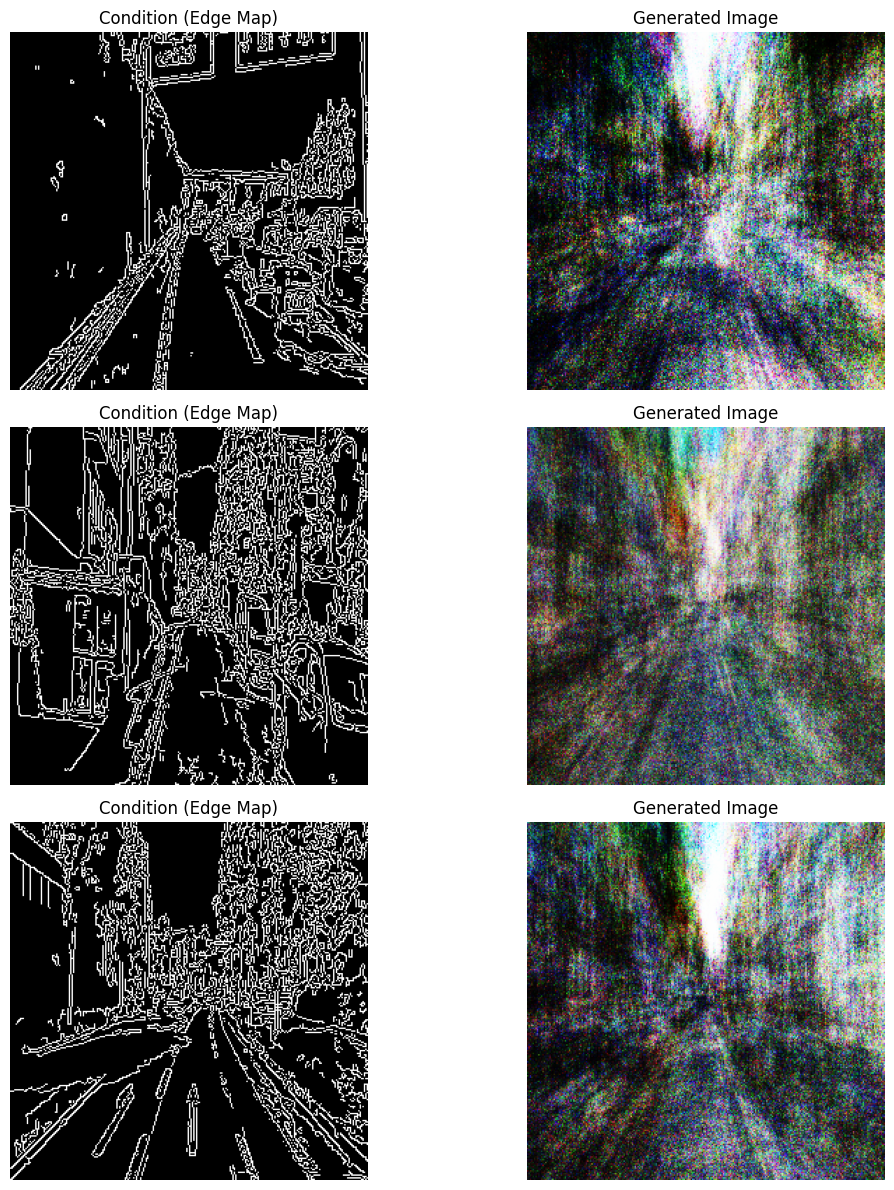

In [78]:
generate_outputs(generator, val_loader, device)

In [85]:

from pytorch_fid.inception import InceptionV3
from scipy.linalg import sqrtm
import torch
import numpy as np

def compute_fid_from_dataloader(generator, real_loader, device, noise_dim=100, num_samples=1000):
    """
    Compute the FID score between real and generated images directly from DataLoaders.
    
    Args:
        generator (nn.Module): The trained generator model.
        real_loader (DataLoader): DataLoader for real images.
        device (torch.device): The device to run computations on.
        noise_dim (int): Dimension of the noise vector for the generator.
        num_samples (int): Number of images to use for FID calculation.
    
    Returns:
        float: FID score.
    """
    # Load InceptionV3 model for feature extraction
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    inception_model = InceptionV3([block_idx]).to(device)
    inception_model.eval()

    # Collect features for real and generated images
    real_features = []
    generated_features = []
    real_count, generated_count = 0, 0
    
    with torch.no_grad():
        # Process real images
        for real_batch in real_loader:
            _, real_images = real_batch  # Assuming (condition, real_image) from the DataLoader
            real_images = real_images.to(device)
            real_images = (real_images + 1) / 2  # Rescale to [0, 1]
            
            # Extract features using InceptionV3
            real_features_batch = inception_model(real_images)[0].view(real_images.size(0), -1).cpu().numpy()
            real_features.append(real_features_batch)
            
            real_count += real_images.size(0)
            if real_count >= num_samples:
                break

        # Generate fake images and extract features
        for real_batch in real_loader:
            conditions, _ = real_batch  # Using conditions from the same DataLoader
            conditions = conditions.to(device)
            
            # Generate fake images
            noise = torch.randn(conditions.size(0), noise_dim, device=device)
            generated_images = generator(noise, conditions)
            generated_images = (generated_images + 1) / 2  # Rescale to [0, 1]
            
            # Extract features using InceptionV3
            generated_features_batch = inception_model(generated_images)[0].view(generated_images.size(0), -1).cpu().numpy()
            generated_features.append(generated_features_batch)
            
            generated_count += generated_images.size(0)
            if generated_count >= num_samples:
                break

    # Combine features
    real_features = np.concatenate(real_features[:num_samples], axis=0)
    generated_features = np.concatenate(generated_features[:num_samples], axis=0)

    # Compute mean and covariance
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_generated, sigma_generated = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    # Compute FID
    diff = mu_real - mu_generated
    covmean = sqrtm(sigma_real.dot(sigma_generated))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_real + sigma_generated - 2 * covmean)
    print(f"FID Score: {fid}")
    return fid

# Example Usage
# Assume `real_loader` is your DataLoader for the real images and `generator` is your trained generator
fid_score = compute_fid_from_dataloader(generator, train_loader, device, noise_dim=100, num_samples=10)
print(fid_score)


FID Score: 410.44560074842207
410.44560074842207


In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import inception_v3
from torchvision.transforms import functional as TF
import numpy as np

def compute_inception_score(generator, dataloader, device, noise_dim=100, num_images=10, splits=10):
    """
    Compute the Inception Score of generated images using PyTorch's InceptionV3.
    
    Args:
        generator (nn.Module): Trained generator model.
        dataloader (DataLoader): DataLoader providing conditions for generating images.
        device (torch.device): Device to perform computation on.
        noise_dim (int): Dimension of the noise vector for the generator.
        num_images (int): Number of generated images to evaluate.
        splits (int): Number of splits for calculating the inception score.

    Returns:
        float: Mean Inception Score.
        float: Standard deviation of Inception Score.
    """
    # Load pre-trained InceptionV3
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    def get_preds(images):
        """Helper function to get softmax predictions from InceptionV3."""
        images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
        preds = inception_model(images)
        return F.softmax(preds, dim=1)

    # Generate images and collect predictions
    preds = []
    count = 0
    generator.eval()
    with torch.no_grad():
        for conditions, _ in dataloader:
            conditions = conditions.to(device)
            noise = torch.randn(conditions.size(0), noise_dim, device=device)
            fake_images = generator(noise, conditions)
            fake_images = (fake_images + 1) / 2  # Rescale to [0, 1]
            
            preds.append(get_preds(fake_images))
            count += fake_images.size(0)
            if count >= num_images:
                break

    # Combine predictions and limit to num_images
    preds = torch.cat(preds, dim=0)[:num_images]

    # Compute inception score
    split_scores = []
    preds = preds.cpu().numpy()
    for k in range(splits):
        part = preds[k * (num_images // splits): (k + 1) * (num_images // splits), :]
        py = np.mean(part, axis=0)
        scores = part * (np.log(part) - np.log(py + 1e-6))
        split_scores.append(np.exp(np.mean(np.sum(scores, axis=1))))

    mean_score = np.mean(split_scores)
    std_score = np.std(split_scores)
    
    print(f"Inception Score: {mean_score} ± {std_score}")
    return mean_score, std_score

# Example usage for 10 images
inception_mean, inception_std = compute_inception_score(generator, train_loader, device, noise_dim=100, num_images=10)
print(f"Inception Score for 10 images: {inception_mean} ± {inception_std}")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 209MB/s] 


Inception Score: 0.9990030527114868 ± 4.823927497454861e-07
Inception Score for 10 images: 0.9990030527114868 ± 4.823927497454861e-07


In [96]:
import lpips
import torch

def compute_lpips_from_dataloader(generator, dataloader, device, noise_dim=100, num_images=10):
    """
    Compute LPIPS between real and generated images using a DataLoader.
    
    Args:
        generator (nn.Module): Trained generator model.
        dataloader (DataLoader): DataLoader providing conditions and real images.
        device (torch.device): Device to perform computation on.
        noise_dim (int): Dimension of the noise vector for the generator.
        num_images (int): Number of image pairs to evaluate.

    Returns:
        float: Mean LPIPS score.
    """
    # Initialize LPIPS metric
    loss_fn = lpips.LPIPS(net='alex').to(device)
    
    lpips_scores = []
    count = 0

    generator.eval()
    with torch.no_grad():
        for conditions, real_images in dataloader:
            conditions, real_images = conditions.to(device), real_images.to(device)
            
            # Generate fake images
            noise = torch.randn(conditions.size(0), noise_dim, device=device)
            generated_images = generator(noise, conditions)
            
            # Rescale images to [0, 1] range (LPIPS expects normalized images)
            real_images = (real_images + 1) / 2
            generated_images = (generated_images + 1) / 2
            
            # Compute LPIPS score for each pair
            batch_lpips = loss_fn(real_images, generated_images)
            lpips_scores.extend(batch_lpips.cpu().numpy())

            count += real_images.size(0)
            if count >= num_images:
                break

    # Calculate mean LPIPS score
    lpips_mean = np.mean(lpips_scores[:num_images])
    print(f"LPIPS Score: {lpips_mean}")
    return lpips_mean

# Example usage for 10 image pairs
lpips_score = compute_lpips_from_dataloader(generator, train_loader, device, noise_dim=100, num_images=10)
print(f"LPIPS Score for 10 image pairs: {lpips_score}")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 198MB/s] 


Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


/opt/conda/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

LPIPS Score: 0.9868915677070618
LPIPS Score for 10 image pairs: 0.9868915677070618
